# ALAC website usage

Author: Jaime Lopez  

In [1]:
# Libraries setup
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
from lxml import html
from fbprophet import Prophet
from mpl_toolkits.basemap import Basemap, cm
import pygeoip
%matplotlib inline

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


ModuleNotFoundError: No module named 'pygeoip'

## Data preparation

In [2]:
! rsync -av --delete root@alac.funde.org:ALAC/log/hits .

receiving incremental file list
hits/
hits/201905
hits/201906

sent 279 bytes  received 3,288,281 bytes  95,320.58 bytes/sec
total size is 34,041,831  speedup is 10.35


In [12]:
base_path = 'hits/'
starting_month = '201801'
ending_month = '201905'

In [13]:
lines = []
for month in os.listdir('hits'):
    if month >= starting_month and month <= ending_month:
        with open(base_path + month, 'r') as fd:
            lines += fd.readlines()

In [14]:
data = []
for item in lines:
    fields = item.strip().split(' ')
    if len(fields) >= 3:
        data.append({"Date": fields[0], "Time": fields[1], "IP": fields[2], "Resource": fields[3]})

In [15]:
df = pd.DataFrame(data)
df = df[df.IP != '190.5.129.245']
df.to_csv('visitas.csv', index=False)

## Basic analysis

In [16]:
df = pd.read_csv('visitas.csv')

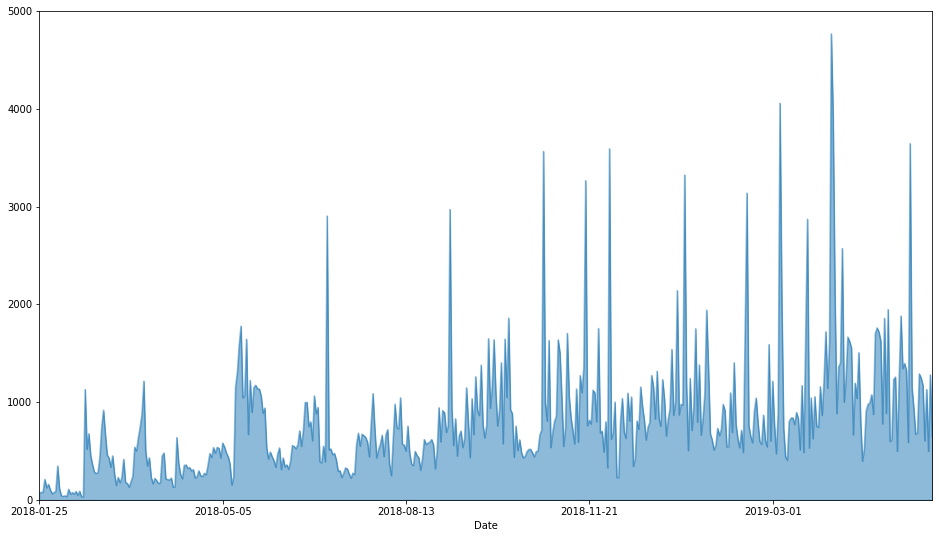

In [17]:
plt.figure(figsize=(16,9))
gb = df.groupby(['Date']).count()
plt.xticks(rotation=90)
gb['IP'].plot(kind='area', alpha=0.5)
plt.savefig('output_img/visitas.png')

In [18]:
print("Average Daily Hits: %f" % gb.Resource.mean())

Average Daily Hits: 796.741803


In [19]:
df['month'] = df.Date.apply(lambda x: x[0:7])
df.to_csv('visitas.csv')
tbl = df.groupby(['month'])['month'].count() / 1000

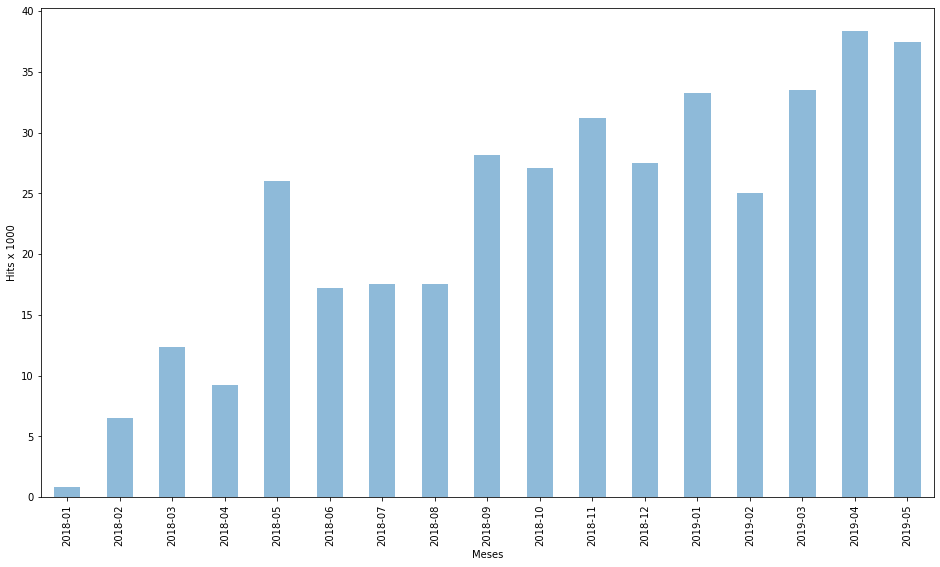

In [20]:
plt.figure(figsize=(16,9))
ax = tbl.plot(kind='bar', alpha=0.5)
ax.set_ylabel("Hits x 1000")
ax.set_xlabel('Meses')
f = ax.get_figure()
f.savefig('output_img/visitas-mes.png')

In [21]:
pd.DataFrame(tbl * 1e3)

,month
month,
2018-01,820.0
2018-02,6552.0
2018-03,12388.0
2018-04,9229.0
2018-05,26021.0
2018-06,17199.0
2018-07,17577.0
2018-08,17516.0
2018-09,28135.0


## Prediction

In [36]:
by_day = df.groupby('Date').count()['IP'].reset_index()
by_day.rename(columns={'Date': 'ds', 'IP': 'y'}, inplace=True)
by_day.head()

,ds,y
0,2018-01-25,74
1,2018-01-26,75
2,2018-01-27,78
3,2018-01-28,209
4,2018-01-29,123


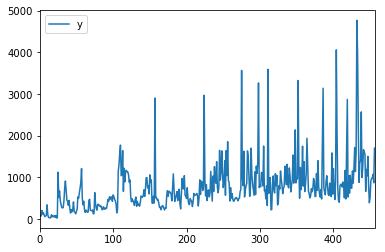

In [44]:
by_day.plot()

In [38]:
m = Prophet()
m.fit(by_day)

/usr/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)

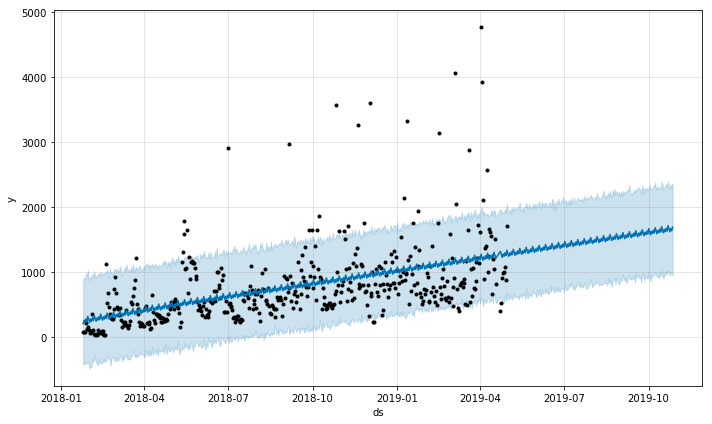

In [50]:
f = m.plot(forecast)

In [52]:
f.savefig('forecast.png')

## Last month

In [22]:
df = pd.read_csv('visitas.csv')

In [23]:
def getReferences(path):
    url = 'https://alac.funde.org' + path
    page = requests.get(url).content
    content = html.fromstring(page)
    title = content.xpath('//h3/text()')[0]
    office = content.xpath('//div[@id="office"]/a/text()')[0]
    date = content.xpath('//div[@id="reference"]/text()')[1].strip().split(':')[1].strip()
    rec = {'title': title, 'office': office, 'date': date, 'url': url}
    return rec

In [24]:
def getResources(month, resource, limit=10):
    mm = month[0:4] + '-' + month[4:]
    data = df[df.month == mm].groupby(by=['Resource']).count()['month'].reset_index()
    data = data[data.Resource.str.contains('/%s/' % resource)].sort_values('month', ascending=False)[0:limit]
    ret = []
    for idx in range(len(data)):
        row = data.iloc[idx]
        rec = getReferences(row.Resource)
        rec['hits'] = row.month
        ret.append(rec)
    return pd.DataFrame(ret)

In [25]:
requests = getResources(ending_month, 'requests')
requests.to_csv('output_data/requests_most_%s.csv' % ending_month, index=False)
requests

,date,hits,office,title,url
0,2013-07-03,35,Instituto Salvadoreño del Seguro Social,Protocolo de atención a casos de Esterilizació...,https://alac.funde.org/requests/5a6613ab97b7ea...
1,2019-03-08,34,Dirección General de Centros Penales,Información de la la Asociación Yo Cambio (ASO...,https://alac.funde.org/requests/5c829b533b7750...
2,2012-06-10,29,Centro Nacional de Registros,Informe sobre Chambita Medidor,https://alac.funde.org/requests/5a6787ee97b7ea...
3,2016-07-20,28,Comisión Ejecutiva Portuaria Autonóma,Salarios y Dietas de presidente y Junta Direct...,https://alac.funde.org/requests/58091bb0ab0857...
4,2018-02-02,25,Ministerio de Hacienda,Base de datos del Presupuesto General del Est...,https://alac.funde.org/requests/5a74dffd97b7ea...
5,2017-10-17,25,Corte de Cuentas de la República,Informes de Auditoría o Exámenes Especiales a ...,https://alac.funde.org/requests/59ee60bdc56bd1...
6,2017-01-12,21,Presidencia de la República,Reglamento de la ley del organismo de intelige...,https://alac.funde.org/requests/5877f7ebab0857...
7,2018-10-09,21,Ministerio de Gobernación,Datos de la Conferencia Evangélica de las Asam...,https://alac.funde.org/requests/5bbcfcbf20d8e7...
8,2014-06-04,20,Alcaldía de San Salvador,"Quinta Itsmania, Colonia Escalón",https://alac.funde.org/requests/5b046e8597b7ea...
9,2013-08-29,17,Ministerio de la Defensa Nacional,Información sobre Coronel Inocente Orlando Mon...,https://alac.funde.org/requests/5a663de297b7ea...


In [28]:
complains = getResources(ending_month, 'complains')
complains.to_csv('output_data/complains_most_%s.csv' % ending_month, index=False)
complains

,date,hits,office,title,url
0,2018-06-19,30,Organo Judicial y Corte Suprema de Justicia,CSJ: Reserva sobre casos sobre enriquecimiento...,https://alac.funde.org/complains/5b29791397b7e...
1,2018-10-09,23,Universidad de El Salvador,Proceso de evaluación docente FIA-UES,https://alac.funde.org/complains/5bbd08b220d8e...
2,2019-03-28,19,Dirección General de Centros Penales,DGCP: apelación y denuncia por no entrega de i...,https://alac.funde.org/complains/5c9cebf33b775...
3,2016-11-16,18,Presidencia de la República,Listado solicitudes de información tramitadas ...,https://alac.funde.org/complains/582dc9ddab085...
4,2016-09-01,18,Centro Nacional de Registros,Pago de aranceles en CNR por copias de balances,https://alac.funde.org/complains/57c890b9ab3ab...
5,2019-04-12,18,Dirección General de Centros Penales,Centros Penales: registros contables y auditor...,https://alac.funde.org/complains/5cb0f79b3b775...
6,2019-04-23,17,Alcaldía de Antiguo Cuscatlán,Antiguo Cuscatlán: denuncia por no tramitar so...,https://alac.funde.org/complains/5cbf49213b775...
7,2017-11-08,16,Alcaldía Puerto de la Libertad,La Libertad: Acta de municipio libre de violen...,https://alac.funde.org/complains/5a038088c56bd...
8,2017-06-22,15,Ministerio de Hacienda,Apelación Ministerio de Hacienda información d...,https://alac.funde.org/complains/594bfcc4c56bd...
9,2018-06-19,14,Ministerio de Medio Ambiente y Recursos Naturales,Denuncia contra el MARN por no entregar inform...,https://alac.funde.org/complains/5b29423497b7e...


## Maps

In [26]:
df = pd.read_csv('visitas.csv')
mm = ending_month[0:4] + '-' + ending_month[4:]
ip = df[df.month == mm].groupby(by='IP').count().sort_values(by=['month'], ascending=False).index

In [27]:
gi4 = pygeoip.GeoIP('/usr/share/GeoIP/GeoIPCity.dat')
gi6 = pygeoip.GeoIP('/usr/share/GeoIP/GeoIPCityv6.dat')

In [28]:
geo = []
counter = 0
for el in ip:
    counter += 1
    a = gi6.record_by_addr(el) if el.find(':') > 0 else gi4.record_by_addr(el)
    geo.append(a)

latitude = []
longitude = []
city = []
country = []
for el in geo:
    if el:
        latitude.append(el['latitude'])
        longitude.append(el['longitude'])
        city.append(el['city'])
        country.append(el['country_code'])

latlong = pd.DataFrame({'latitude': latitude, 'longitude': longitude, 'item': range(len(longitude)), 'city': city,
                       'country': country})

ll = latlong.groupby(by=['latitude', 'longitude']).count()

In [29]:
ll.item = ll.item / max(ll.item)
ll.reset_index(level=0, inplace=True)
ll.reset_index(level=0, inplace=True)
ll.head()

,longitude,latitude,item,city,country
0,-71.2917,-41.1333,0.001429,1,1
1,-66.9042,-39.0000,0.001429,1,1
2,-62.7167,-37.5500,0.001429,1,1
3,-73.0500,-36.8333,0.001429,1,1
4,-59.0947,-35.1853,0.001429,1,1


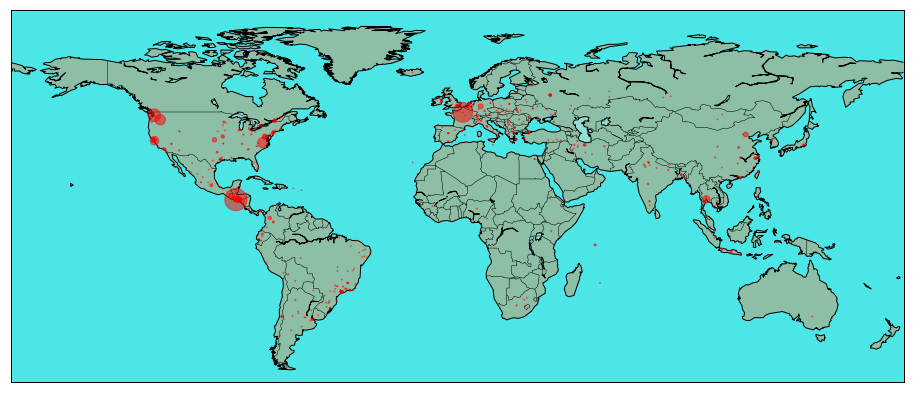

In [30]:
plt.figure(figsize=(16,9))
m = Basemap(llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=90.)
m.drawcoastlines()
m.drawmapboundary(fill_color=(0.3, 0.9, 0.9))
m.drawcountries()
m.fillcontinents(color='#cc9966', lake_color='#99ffff', alpha=0.5)
m.scatter(ll.longitude, ll.latitude, ll.item*500, marker = 'o', color='r', alpha=0.5, zorder=5)
plt.savefig('output_img/visitas_mundo_%s.png' % ending_month)

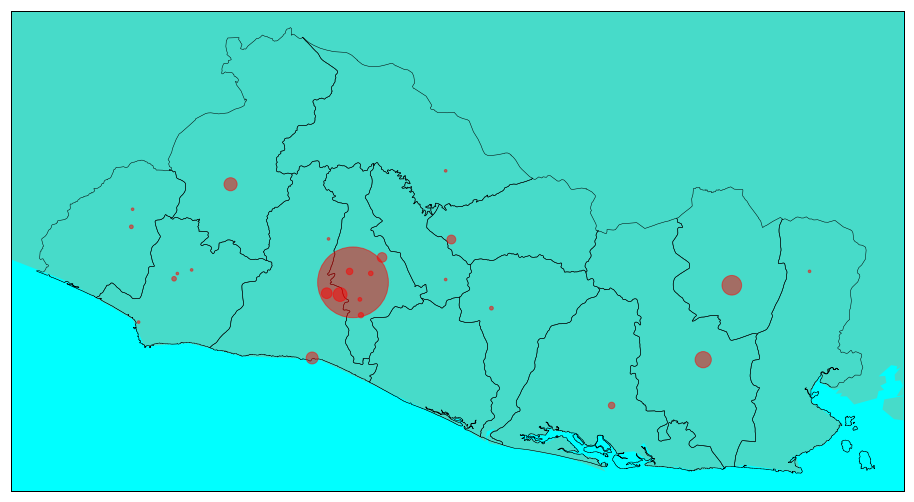

In [31]:
plt.figure(figsize=(16,9))
m = Basemap(llcrnrlon=-90.2,llcrnrlat=13.1,urcrnrlon=-87.6,urcrnrlat=14.5, resolution='i')
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='#cc9966', lake_color='#99ffff', alpha=0.35)
# m.drawcoastlines()
m.readshapefile('third/SLV_adm1', 'depto')
m.scatter(ll.longitude, ll.latitude, ll.item*5000, marker = 'o', color='r', alpha=0.5, zorder=5)
plt.savefig('output_img/visitas_elsalvador_%s.png' % ending_month)